# DAT 490 Capstone Methodolgy
## Analyzing Food Deserts and Food Insecurity in the United States
### By Haley Allen, Philip Krause, and Amoreena Ordoñez

In [1]:
## importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.over_sampling import SMOTE, ADASYN

from scipy import stats as st

C:\Users\phikr\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
## Reading fara dataset
path1 = "FoodAccessResearchAtlasData2019.xlsx"
fara = pd.read_excel(path1, sheet_name = "Food Access Research Atlas") 

## Random Forest Model

In [4]:
## Choosing columns that are appropriate for Random Forest model
rf_columns = ["PovertyRate", "MedianFamilyIncome", "TractKids", "TractSeniors","TractWhite", "TractBlack", "TractAsian", "TractNHOPI", "TractAIAN",
               "TractOMultir", "TractHispanic", "TractHUNV", "TractSNAP",'LILATracts_halfAnd10']

fara_rf = fara[rf_columns]
fara_rf.head()

,PovertyRate,MedianFamilyIncome,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,LILATracts_halfAnd10
0,11.336453,81250.0,507.0,221.0,1622.0,217.0,14.0,0.0,14.0,45.0,44.0,6.0,102.0,0
1,17.876788,49000.0,606.0,214.0,888.0,1217.0,5.0,0.0,5.0,55.0,75.0,89.0,156.0,1
2,15.046030,62609.0,894.0,439.0,2576.0,647.0,17.0,5.0,11.0,117.0,87.0,99.0,172.0,0
3,2.845210,70607.0,1015.0,904.0,4086.0,193.0,18.0,4.0,11.0,74.0,85.0,21.0,98.0,0
4,15.150891,96334.0,3162.0,1126.0,8666.0,1437.0,296.0,9.0,48.0,310.0,355.0,230.0,339.0,0


In [5]:
## Looking at Nan totals, then dropping rows
nan_counts = fara_rf.isna().sum()
print(nan_counts)

fara_rf = fara_rf.dropna()

PovertyRate               3
MedianFamilyIncome      748
TractKids                 4
TractSeniors              4
TractWhite                4
TractBlack                4
TractAsian                4
TractNHOPI                4
TractAIAN                 4
TractOMultir              4
TractHispanic             4
TractHUNV                 4
TractSNAP                 4
LILATracts_halfAnd10      0
dtype: int64


In [6]:
## Separating into training and testing splits
predictors = ["PovertyRate", "MedianFamilyIncome", "TractKids", "TractSeniors","TractWhite", "TractBlack", "TractAsian", "TractNHOPI", "TractAIAN",
              "TractOMultir", "TractHispanic", "TractHUNV", "TractSNAP"]

X = fara_rf[predictors]
y = fara_rf['LILATracts_halfAnd10']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Creating Random Forest model for LILA tracts
rf_model = RandomForestClassifier(random_state=123)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

## Showing accuracy results of model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
pd.crosstab(y_pred, y_test)

Accuracy: 0.8641777530124678


LILATracts_halfAnd10,0,1
row_0,,
0,9370,927
1,1023,3037


In [146]:
## Using randomized cross validation to find optimal parameters
## THIS CODE TAKES AROUND 25 MINUTES TO RUN
parameters = {
    "n_estimators": [100,200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "max_features": ['log2', 'sqrt']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=123), parameters, cv=3, scoring='accuracy')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Output the best parameters from the grid search
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 200}


In [6]:
## Creating new model based on optimal parameters
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, max_features= 'log2', 
                                  max_depth= None, random_state=123)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
pd.crosstab(y_pred, y_test)

Accuracy: 0.8625060945880059


LILATracts_halfAnd10,0,1
row_0,,
0,9346,927
1,1047,3037


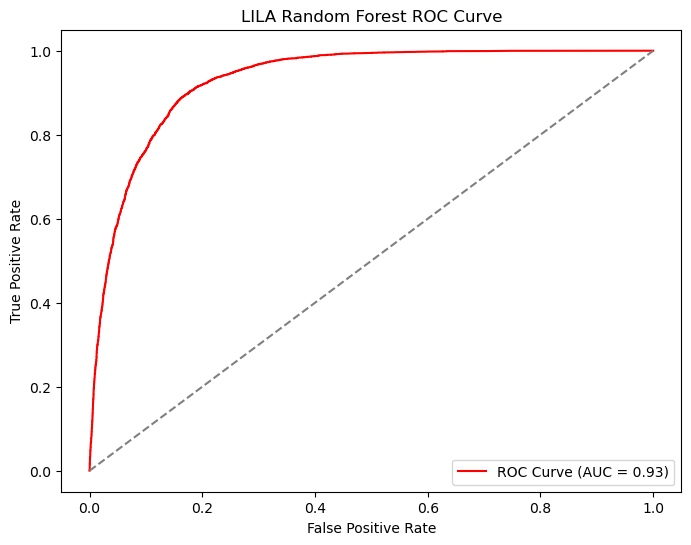

In [7]:
# Creating a probability variable
y_prob = rf_model.predict_proba(X_test)[:, 1]  

# Getting false and true positive rates
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Getting area under the curve
auc_score = roc_auc_score(y_test, y_prob)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LILA Random Forest ROC Curve')
plt.legend()
plt.show()

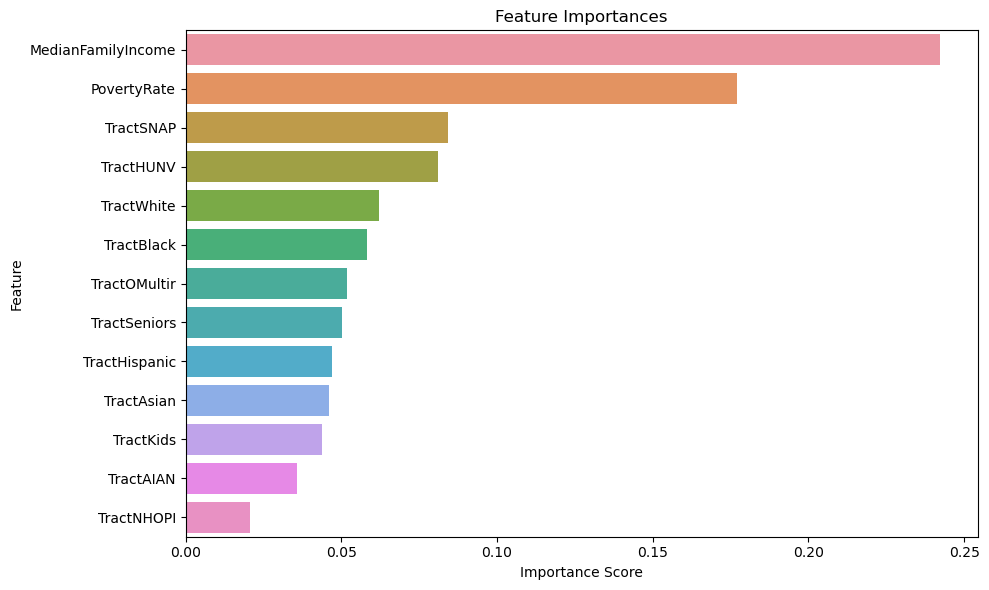

In [8]:
## Plotting important features based on rf model
importances = pd.Series(rf_model.feature_importances_, index=predictors)
# Making plot look good, in descending order
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Random Forest w/ SMOTE

In [7]:
##SMOTE resample minority class
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
y_smote.value_counts()

0    41348
1    41348
Name: LILATracts_halfAnd10, dtype: int64

In [9]:
## rerun random forest model

## Creating Random Forest model for LILA tracts
rf_model = RandomForestClassifier(random_state=123)
rf_model.fit(X_smote, y_smote)
y_pred = rf_model.predict(X_test)

## Showing accuracy results of model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
pd.crosstab(y_pred, y_test)

Accuracy: 0.8554015462840426


LILATracts_halfAnd10,0,1
row_0,,
0,8932,615
1,1461,3349


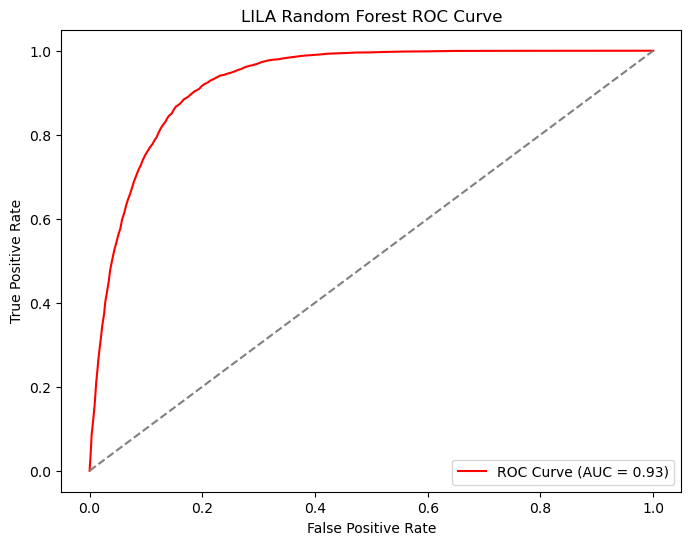

In [10]:
# Creating a probability variable
y_prob = rf_model.predict_proba(X_test)[:, 1]  

# Getting false and true positive rates
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Getting area under the curve
auc_score = roc_auc_score(y_test, y_prob)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LILA Random Forest ROC Curve')
plt.legend()
plt.show()

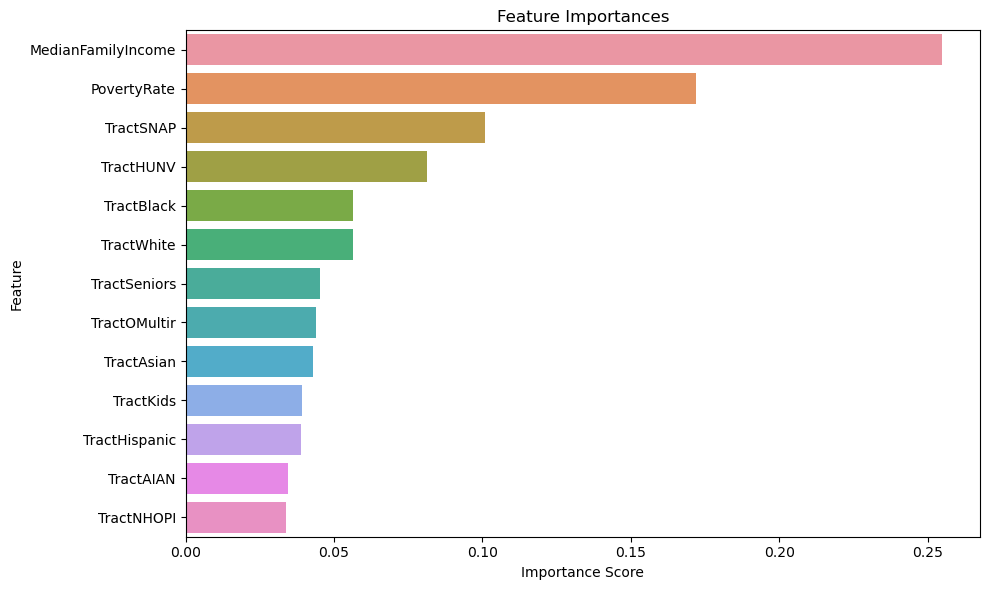

In [11]:
## Plotting important features based on rf model
importances = pd.Series(rf_model.feature_importances_, index=predictors)
# Making plot look good, in descending order
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Random Forest for SNAP

In [101]:
## Creating new data frame to use for rf predicting SNAP usage
column_list_SNAP = ["PovertyRate", "TractLOWI", "TractKids", "TractSeniors","TractWhite", "TractBlack", "TractAsian", "TractNHOPI", "TractAIAN",
               "TractOMultir", "TractHispanic", "TractHUNV", "TractSNAP", 'Urban','LATracts_half','LATracts1','LATracts10','LATracts20',
               'LILATracts_1And10','LILATracts_halfAnd10']

fara_SNAP = fara[column_list_SNAP]

In [103]:
## Again, removing nans
nan_counts = fara_SNAP.isna().sum()
print(nan_counts)

fara_SNAP = fara_SNAP.dropna()

PovertyRate             0
TractLOWI               0
TractKids               0
TractSeniors            0
TractWhite              0
TractBlack              0
TractAsian              0
TractNHOPI              0
TractAIAN               0
TractOMultir            0
TractHispanic           0
TractHUNV               0
TractSNAP               0
Urban                   0
LATracts_half           0
LATracts1               0
LATracts10              0
LATracts20              0
LILATracts_1And10       0
LILATracts_halfAnd10    0
dtype: int64


In [105]:
## Splitting data into test and train splits
predictors_SNAP = ["TractKids", "TractSeniors","TractWhite", "TractBlack", "TractAsian", "TractNHOPI", "TractAIAN", #"TractLOWI", 
               "TractOMultir", "TractHispanic", "TractHUNV", 'Urban','LATracts_half','LATracts10','LILATracts_halfAnd10'] 

X = fara_SNAP[predictors_SNAP]
y = fara_SNAP["TractSNAP"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Creating rf model 
rf_SNAP = RandomForestRegressor(n_estimators=100, random_state=123)
rf_SNAP.fit(X_train, y_train)
y_pred = rf_SNAP.predict(X_test)

## Showing RMSE and R^2 values
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")
print(f"R^2: {r2_score(y_test, y_pred):.2f}")

RMSE: 100.12
R^2: 0.71


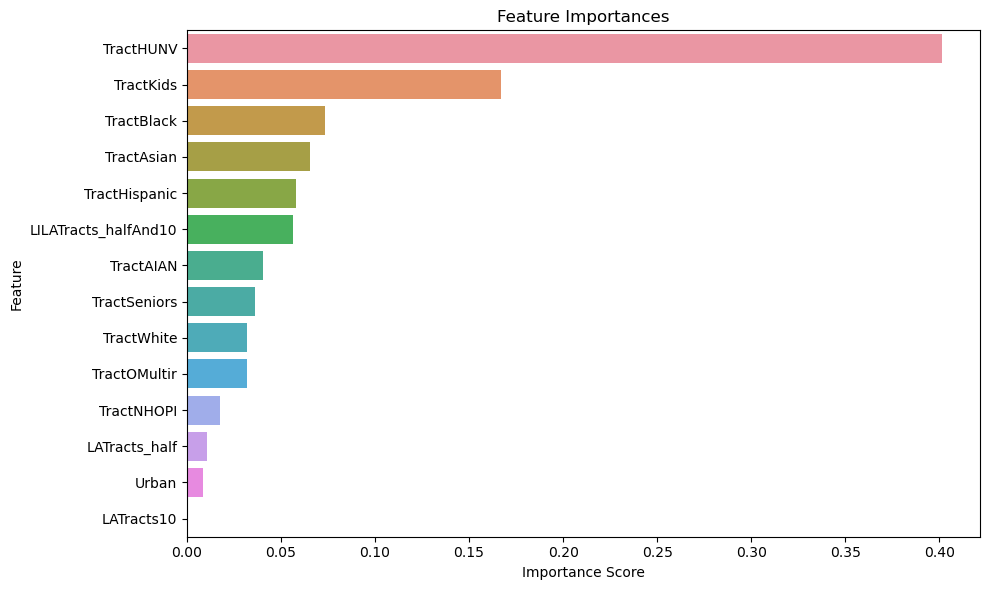

In [107]:
## Plotting importance values 
importances_SNAP = pd.Series(rf_SNAP.feature_importances_, index=predictors_SNAP)
importances_SNAP = importances_SNAP.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_SNAP, y=importances_SNAP.index)
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## FARA  Statistics

In [56]:
fara.shape

(72531, 147)

In [57]:
fara['LILATracts_halfAnd10'].value_counts()
# out of 72531 census tracts, 20247 are flagged as LILATracts_halfAnd10
# The percentage of LILATracts_halfAnd10 in the dataset equals to 27.9%; a little over a 1:4 ratio.
# The percentage of NON-LILATracts_halfAnd10 is 72.1%.

0    52284
1    20247
Name: LILATracts_halfAnd10, dtype: int64

In [30]:
# subsetting census tracts flagged as LILATracts_halfAnd10
df_halfAnd10 = fara[fara['LILATracts_halfAnd10'] == 1]
df_halfAnd10.shape

(20247, 147)

In [32]:
# What is the overall population of low-access and low-income in our dataset? Use this as the baseline metric.
halfAnd10_popprop = round(df_halfAnd10['Pop2010'].sum() / fara['Pop2010'].sum(), 3)
halfAnd10_popprop * 100

26.6

In [34]:
df_NOThalfAnd10 = fara[fara['LILATracts_halfAnd10'] == 0]
df_NOThalfAnd10.shape

(52284, 147)

In [36]:
NONhalfAnd10_popprop = round(df_NOThalfAnd10['Pop2010'].sum() / fara['Pop2010'].sum(), 3)
NONhalfAnd10_popprop * 100
# complement to proportion of dataset population outside of LILATracts_halfAnd10 = 73.4%

73.4

In [38]:
# independent variables: OHU2010, PovertyRate, MedianFamilyIncome, TractKids, TractSeniors, TractWhite,
# TractBlack, TractAsian, TractNHOPI, TractAIAN, TractOMultir, TractHispanic, TractHUNV, TractSNAP

df_halfAnd10 = df_halfAnd10[["OHU2010", "PovertyRate", "MedianFamilyIncome", "TractKids", "TractSeniors", "TractWhite", "TractBlack", "TractAsian", "TractNHOPI", "TractAIAN", "TractOMultir", "TractHispanic", "TractHUNV", "TractSNAP"]]
df_halfAnd10.shape

(20247, 14)

In [40]:
df_halfAnd10.isnull().sum()

OHU2010                 0
PovertyRate             0
MedianFamilyIncome    206
TractKids               0
TractSeniors            0
TractWhite              0
TractBlack              0
TractAsian              0
TractNHOPI              0
TractAIAN               0
TractOMultir            0
TractHispanic           0
TractHUNV               0
TractSNAP               0
dtype: int64

In [42]:
df_halfAnd10 = df_halfAnd10.dropna()
df_halfAnd10.shape

(20041, 14)

In [44]:
df_NOThalfAnd10 = df_NOThalfAnd10[["OHU2010", "PovertyRate", "MedianFamilyIncome", "TractKids", "TractSeniors", "TractWhite", "TractBlack", "TractAsian", "TractNHOPI", "TractAIAN", "TractOMultir", "TractHispanic", "TractHUNV", "TractSNAP"]]
df_NOThalfAnd10.shape

(52284, 14)

In [46]:
df_NOThalfAnd10.isnull().sum()

OHU2010                 0
PovertyRate             3
MedianFamilyIncome    542
TractKids               4
TractSeniors            4
TractWhite              4
TractBlack              4
TractAsian              4
TractNHOPI              4
TractAIAN               4
TractOMultir            4
TractHispanic           4
TractHUNV               4
TractSNAP               4
dtype: int64

In [48]:
df_NOThalfAnd10 = df_NOThalfAnd10.dropna()
df_NOThalfAnd10.shape

(51741, 14)

In [50]:
cols_to_check = ['PovertyRate', 'MedianFamilyIncome', 'TractHUNV','TractSNAP','LILATracts_halfAnd10']
fara[cols_to_check].isna().sum()

PovertyRate               3
MedianFamilyIncome      748
TractHUNV                 4
TractSNAP                 4
LILATracts_halfAnd10      0
dtype: int64

In [52]:
columns_to_drop_na = ['PovertyRate', 'MedianFamilyIncome', 'TractHUNV','TractSNAP']
fara = fara.dropna(subset=columns_to_drop_na)
fara.shape

(71782, 147)

In [54]:
# Prepare the data
X = fara[['PovertyRate', 'MedianFamilyIncome', 'TractHUNV','TractSNAP']]  # Independent variables
y = fara['LILATracts_halfAnd10']  # Dependent, target variable variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

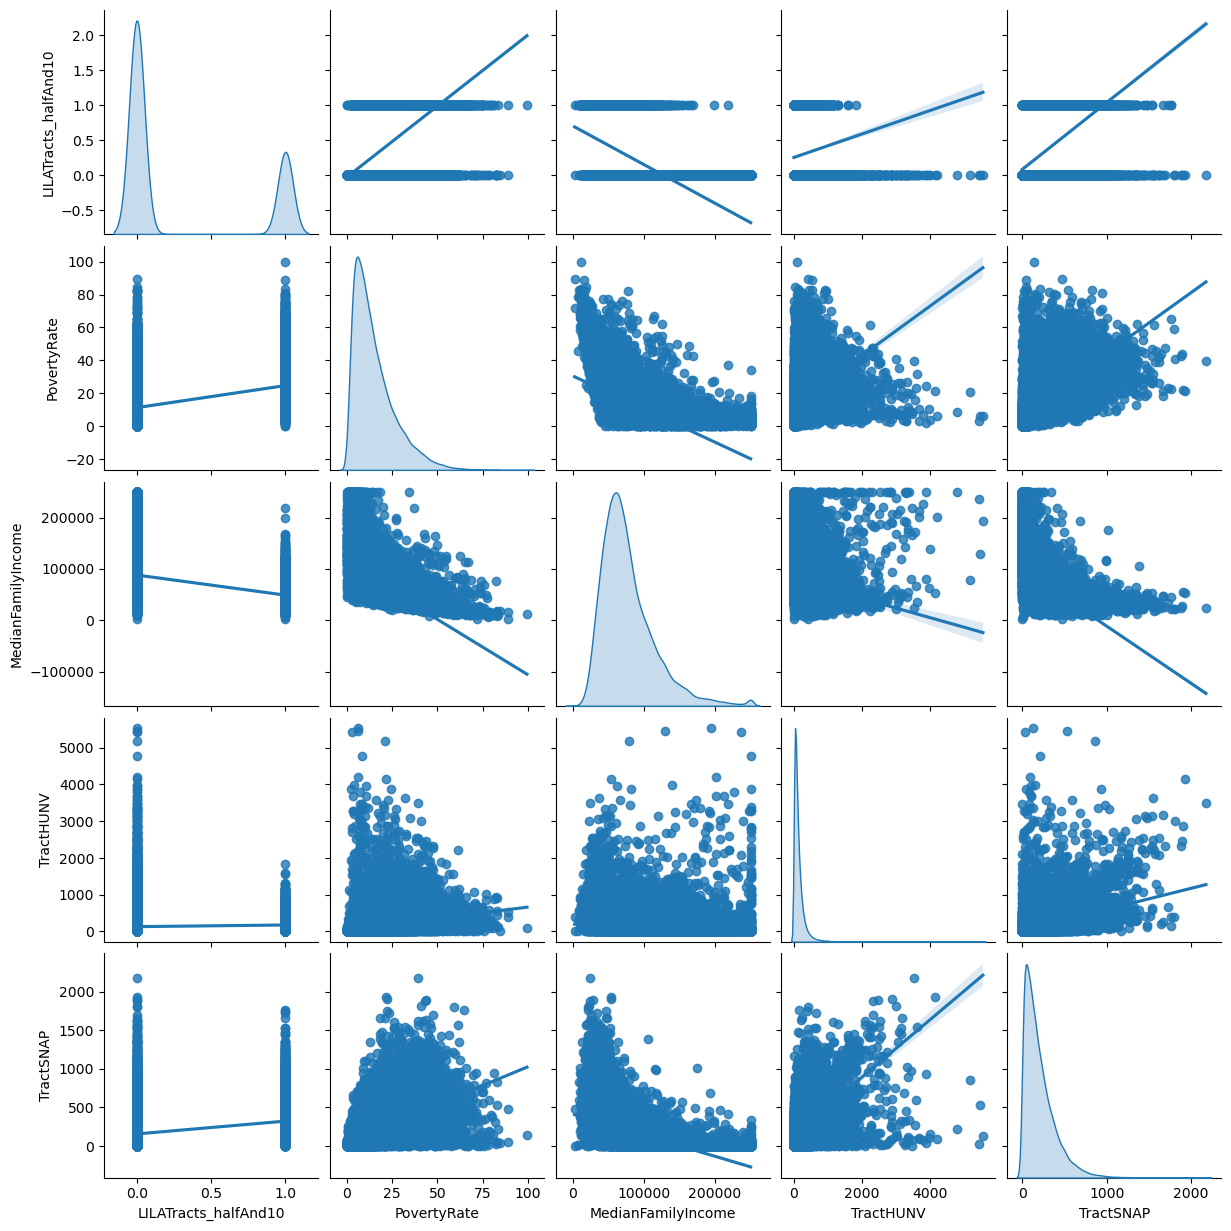

In [71]:
train_dataset = X_train.copy()
train_dataset.insert(0, "LILATracts_halfAnd10", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

## Linear Regression Model SNAP and LILA

In [57]:
# Create and train the model
model1 = LinearRegression()
model1.fit(X_train, y_train)

LinearRegression()

In [59]:
y_pred_lr = model1.predict(X_test)

# y_pred values are continuous, need to convert to binary
y_pred_binary = np.where(y_pred_lr >= 0.5, 1, 0)

mse = mean_squared_error(y_test, y_pred_binary)
r2 = r2_score(y_test, y_pred_binary)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.21267703738100766
R-squared: -0.04994805844084893


In [61]:
# Print the coefficients and intercept
print("Coefficients:", model1.coef_)
print("Intercept:", model1.intercept_)
# 'PovertyRate', 'MedianFamilyIncome', 'TractHUNV','TractSNAP'

Coefficients: [ 1.42167239e-02 -1.88180649e-06 -2.09182020e-04  3.43359600e-04]
Intercept: 0.16923813009281374


In [63]:
model1_cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix :\n{}".format(model1_cm))

Confusion Matrix :
[[14266  1192]
 [ 3388  2689]]


In [65]:
accuracy_lr = accuracy_score(y_test, y_pred_binary)
print("Accuracy Score:", round(accuracy_lr * 100, 5))

Accuracy Score: 78.7323


## Linear Regression w/ SMOTE

In [70]:
## SMOTE resample minority class
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
y_smote.value_counts()

LILATracts_halfAnd10
0    36283
1    36283
Name: count, dtype: int64

In [80]:
# Create and retrain the model
model1 = LinearRegression()
model1.fit(X_smote, y_smote)


LinearRegression()

In [82]:
y_pred_lr = model1.predict(X_test)

# y_pred values are continuous, need to convert to binary
y_pred_binary = np.where(y_pred_lr >= 0.5, 1, 0)

mse = mean_squared_error(y_test, y_pred_binary)
r2 = r2_score(y_test, y_pred_binary)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.19549570466682145
R-squared: 0.03487307291790953


In [84]:
# Print the coefficients and intercept
print("Coefficients:", model1.coef_)
print("Intercept:", model1.intercept_)
# 'PovertyRate', 'MedianFamilyIncome', 'TractHUNV','TractSNAP'

Coefficients: [ 1.26315685e-02 -4.17952548e-06 -2.32655815e-04  3.31647457e-04]
Intercept: 0.5148212675142996


In [86]:
model1_cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix :\n{}".format(model1_cm))

Confusion Matrix :
[[12388  3070]
 [ 1140  4937]]


In [88]:
accuracy_lr = accuracy_score(y_test, y_pred_binary)
print("Accuracy Score:", round(accuracy_lr * 100, 5))

Accuracy Score: 80.45043


## Logistic Regression SNAP

In [86]:
# Create and train the model
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression()

In [87]:
y_pred_logit = model2.predict(X_test)

In [88]:
model2_cm = confusion_matrix(y_test, y_pred_logit)
print("Confusion Matrix :\n{}".format(model2_cm))

Confusion Matrix :
[[14087  1371]
 [ 3003  3074]]


In [89]:
accuracy = accuracy_score(y_test, y_pred_logit)
print("Accuracy Score:", round(accuracy * 100, 5))

Accuracy Score: 79.68888


## Logistic Regression w/ SMOTE

In [91]:
# Create and retrain the model w/ SMOTE
model2 = LogisticRegression()
model2.fit(X_smote, y_smote)

LogisticRegression()

In [93]:
y_pred_logit = model2.predict(X_test)

In [95]:
model2_cm = confusion_matrix(y_test, y_pred_logit)
print("Confusion Matrix :\n{}".format(model2_cm))

Confusion Matrix :
[[12565  2893]
 [ 1289  4788]]


In [97]:
accuracy = accuracy_score(y_test, y_pred_logit)
print("Accuracy Score:", round(accuracy * 100, 5))

Accuracy Score: 80.58045


## SNAP Statistics

In [90]:
# Variable TractSNAP = total count of housing units receiving SNAP benefits in tract
# Variable OHU2010 = housing units total, occupied housing unit count from 2010 census
# added a SNAP proportion column to both subsets

df_halfAnd10['SNAPproportion'] = df_halfAnd10['TractSNAP'] / df_halfAnd10['OHU2010']
df_NOThalfAnd10['SNAPproportion'] = df_NOThalfAnd10['TractSNAP'] / df_NOThalfAnd10['OHU2010']

In [91]:
df_halfAnd10.shape

(20041, 15)

In [92]:
df_NOThalfAnd10.shape

(51741, 15)

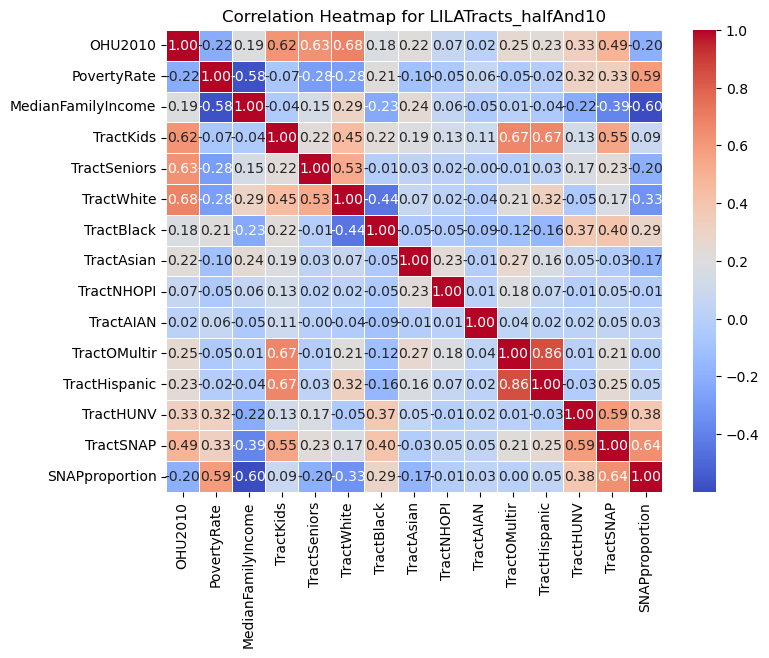

In [94]:
# correlation heatmap for flagged LILATracts_halfAnd10
heatmap1 = df_halfAnd10.corr()#numeric_only=True) -- need updated version of pandas to use, but plot looks the same

plt.figure(figsize=(8, 6)) 
sns.heatmap(heatmap1, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for LILATracts_halfAnd10')
plt.show()

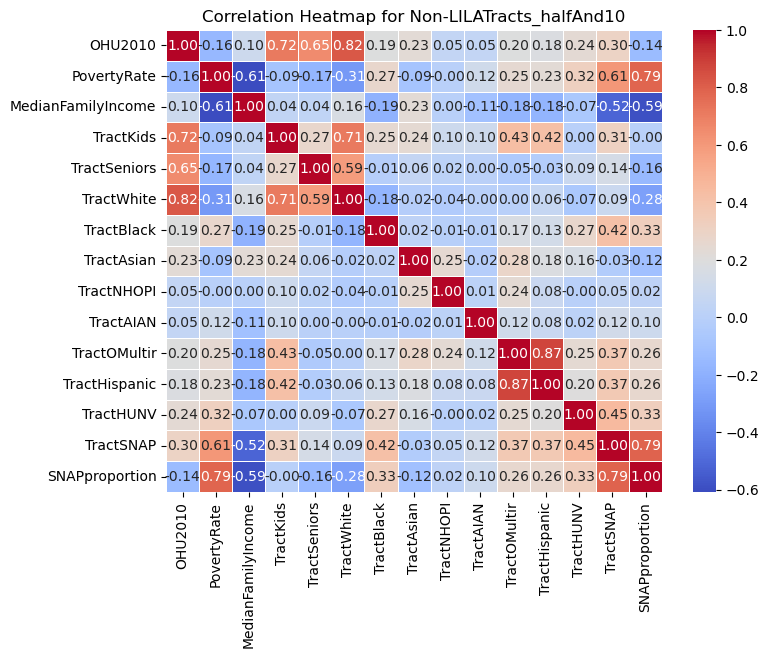

In [95]:
# correlation heatmap for non-flagged LILATracts_halfAnd10
heatmap2 = df_NOThalfAnd10.corr()#numeric_only=True)

plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(heatmap2, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for Non-LILATracts_halfAnd10')
plt.show()

(0.0, 1.0)

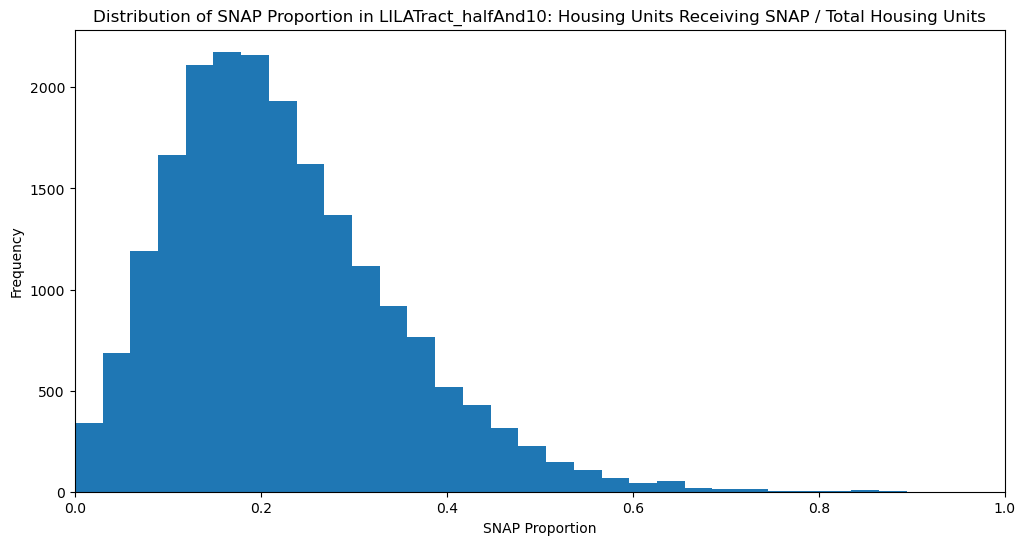

In [148]:
# distribution of SNAP proportion across census tracts within LILATract_halfAnd10
plt.figure(figsize=(12, 6))
plt.hist(df_halfAnd10['SNAPproportion'], bins = 141)
plt.title('Distribution of SNAP Proportion in LILATract_halfAnd10: Housing Units Receiving SNAP / Total Housing Units')
plt.xlabel('SNAP Proportion')
plt.ylabel('Frequency')
plt.xlim(0, 1)

(0.0, 1.0)

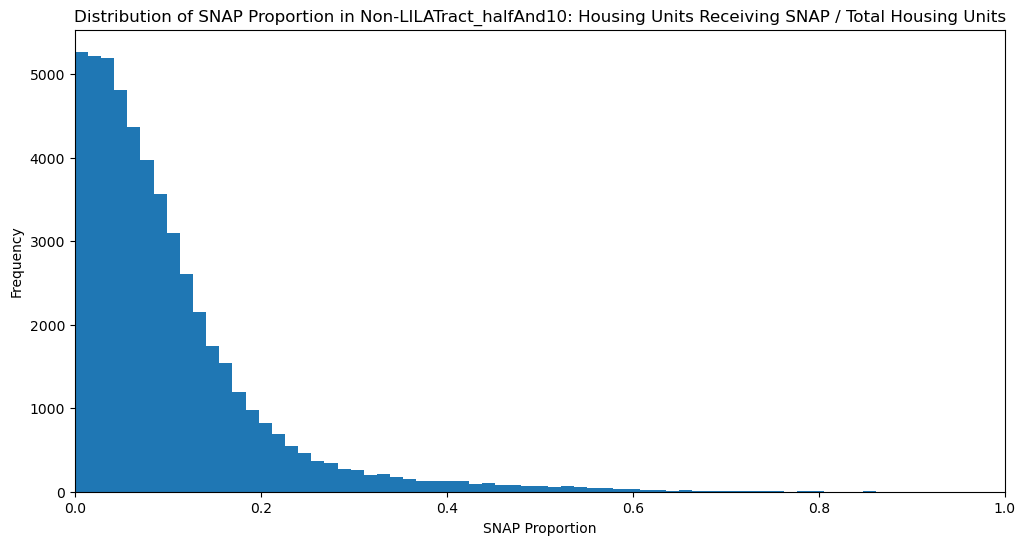

In [149]:
plt.figure(figsize=(12, 6))
plt.hist(df_NOThalfAnd10['SNAPproportion'], bins = 227)
plt.title('Distribution of SNAP Proportion in Non-LILATract_halfAnd10: Housing Units Receiving SNAP / Total Housing Units')
plt.xlabel('SNAP Proportion')
plt.ylabel('Frequency')
plt.xlim(0, 1)

In [106]:
# figure out how to calculate SNAP proportion for entire LILATract_halfAnd10 df by adding up total housing units receiving SNAP benefits
# then dividing it by total housing units in df with 'OHU2010' variable
# proportion of LILATract housing units receiving SNAP benefits = 21.32%
# baseline metric for housing units receiving SNAP in LILATracts

LILAhalfANd10_SNAPprop = df_halfAnd10['TractSNAP'].sum() / df_halfAnd10['OHU2010'].sum()
round(LILAhalfANd10_SNAPprop * 100, 2)

21.32

In [107]:
# do this for df_NOThalfAnd10
# proportion of Non-LILATract housing units receiving SNAP benefits = 9.43%
# baseline metric for housing units receiving SNAP in Non-LILATracts

NonLILAhalfAnd10_SNAPprop = df_NOThalfAnd10['TractSNAP'].sum() / df_NOThalfAnd10['OHU2010'].sum()
round(NonLILAhalfAnd10_SNAPprop * 100, 2)

9.43

In [108]:
fara_SNAPprop = fara['TractSNAP'].sum() / fara['OHU2010'].sum()
round(fara_SNAPprop * 100, 5)
# SNAP proportion in entire dataset = 12.53%

12.5257

In [110]:
fara['SNAPproportion'] = fara['TractSNAP'] / fara['OHU2010']
fara.shape

(71782, 148)

(0.0, 1.0)

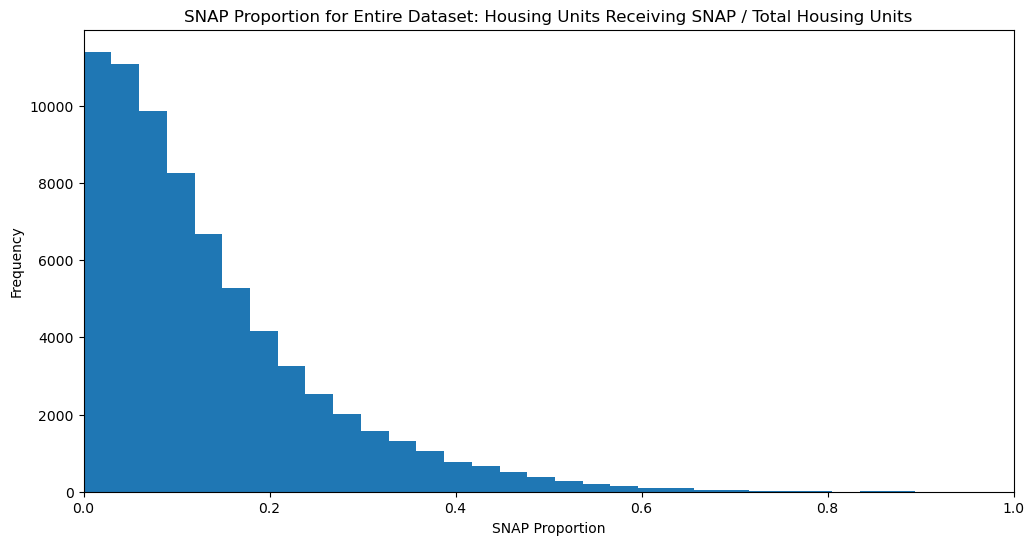

In [150]:
plt.figure(figsize=(12, 6))
plt.hist(fara['SNAPproportion'], bins = 141)
plt.title('SNAP Proportion for Entire Dataset: Housing Units Receiving SNAP / Total Housing Units')
plt.xlabel('SNAP Proportion')
plt.ylabel('Frequency')
plt.xlim(0, 1)

## Measures of central tendency

In [113]:
df_halfAnd10['TractSNAP'].describe()

count    20041.000000
mean       322.186917
std        199.878475
min          0.000000
25%        180.000000
50%        285.000000
75%        423.000000
max       1888.000000
Name: TractSNAP, dtype: float64

In [114]:
df_NOThalfAnd10['TractSNAP'].describe()

count    51741.000000
mean       157.065596
std        157.204693
min          0.000000
25%         51.000000
50%        114.000000
75%        212.000000
max       2175.000000
Name: TractSNAP, dtype: float64

In [115]:
df_halfAnd10['SNAPproportion'].describe()

count    20041.000000
mean         0.224155
std          0.127576
min          0.000000
25%          0.135394
50%          0.204400
75%          0.293043
max          4.203704
Name: SNAPproportion, dtype: float64

In [116]:
df_NOThalfAnd10['SNAPproportion'].describe()

count    51741.000000
mean         0.100736
std          0.101271
min          0.000000
25%          0.034978
50%          0.074074
75%          0.131455
max          3.206667
Name: SNAPproportion, dtype: float64

In [117]:
df_halfAnd10['TractSNAP'].median()
# median number of housing units within a LILATract_halfAnd10 census tract receiving SNAP benefits

285.0

In [118]:
df_halfAnd10['SNAPproportion'].median()
# median proportion of housing units within a LILATract_halfAnd10 census tract receiving SNAP benefits

0.20439963336388633

In [119]:
df_NOThalfAnd10['TractSNAP'].median()
# median number of housing units within a NON-LILATract_halfAnd10 census tract receiving SNAP benefits

114.0

In [120]:
df_NOThalfAnd10['SNAPproportion'].median()
# median proportion of housing units within a NON-LILATract_halfAnd10 census tract receiving SNAP benefits

0.07407407407407407

In [121]:
st.tvar(df_halfAnd10['TractSNAP'], ddof=1)
# variance of SNAP-receiving housing units in LILATracts_halfAnd10

39951.40488071808

In [122]:
st.tvar(df_NOThalfAnd10['TractSNAP'], ddof=1)
# variance of SNAP-receiving housing units in Non-LILATracts_halfAnd10

24713.315642971567

In [123]:
st.tvar(df_halfAnd10['SNAPproportion'], ddof=1)
# variance of SNAP proportion in LILATracts_halfAnd10

0.016275556000322027

In [124]:
st.tvar(df_NOThalfAnd10['SNAPproportion'], ddof=1)
# variance of SNAP proportion in Non-LILATracts_halfAnd10

0.010255894206410864

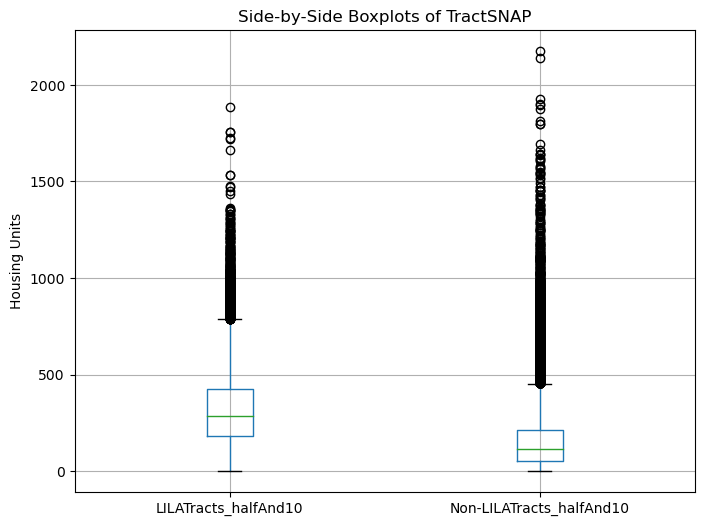

In [125]:
boxplot_TractSNAP = pd.DataFrame({'LILATracts_halfAnd10': df_halfAnd10['TractSNAP'], 'Non-LILATracts_halfAnd10': df_NOThalfAnd10['TractSNAP']})
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
boxplot_TractSNAP.boxplot()
plt.title('Side-by-Side Boxplots of TractSNAP')
plt.ylabel('Housing Units')
plt.show()

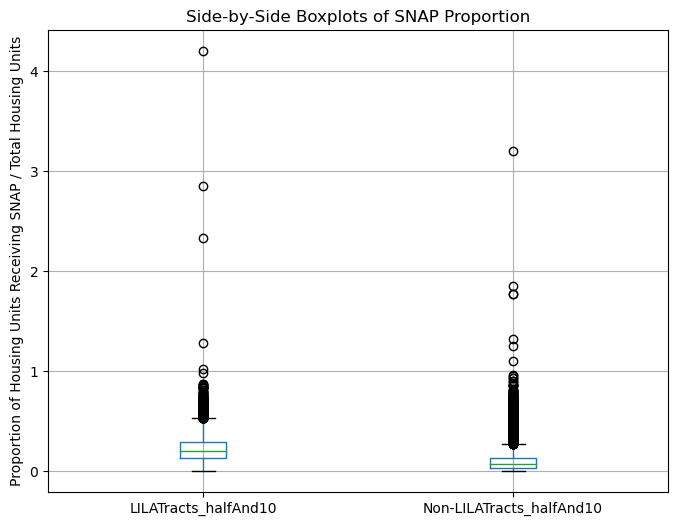

In [126]:
boxplot_SNAPprop = pd.DataFrame({'LILATracts_halfAnd10': df_halfAnd10['SNAPproportion'], 'Non-LILATracts_halfAnd10': df_NOThalfAnd10['SNAPproportion']})
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
boxplot_SNAPprop.boxplot()
plt.title('Side-by-Side Boxplots of SNAP Proportion')
plt.ylabel('Proportion of Housing Units Receiving SNAP / Total Housing Units')
plt.show()

In [127]:
from scipy.stats import sem # standard error mean

round(sem(df_halfAnd10['TractSNAP']),3)

1.412

In [128]:
round(sem(df_halfAnd10['SNAPproportion']),3)

0.001

In [129]:
round(sem(df_NOThalfAnd10['TractSNAP']),3)

0.691

In [130]:
round(sem(df_NOThalfAnd10['SNAPproportion']),3)

0.0

## Statistical Testing

In [131]:
# null hypothesis: There is no difference in the number of housing units receiving SNAP benefits between LILATracts_halfAnd10 and Non-LILATracts_halfand10.
# Low-income: a poverty rate of 20 percent or greater,
# or a median family income at or below 80 percent of the statewide or metropolitan area median family income
# povertyrate variable = the proportion of the tract population living with income at or below the Federal poverty thresholds for family size

In [132]:
# null hypothesis: SNAP participation is greater in LILATracts_halfAnd10 than Non-LILATracts_halfAnd10

In [133]:
# Perform Welch's t-test (unequal variances and sample sizes, two samples from the same population)
t_statistic, p_value = st.ttest_ind(df_halfAnd10['TractSNAP'], df_NOThalfAnd10['TractSNAP'], equal_var=False)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Check for significance (e.g., at alpha = 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")

T-statistic: 105.04039681368121
P-value: 0.0
Reject the null hypothesis: There is a significant difference between the means.


In [134]:
t_statistic, p_value = st.ttest_ind(df_halfAnd10['TractSNAP'], df_NOThalfAnd10['TractSNAP'])

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Check for significance (e.g., using alpha = 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the two groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two groups.")

T-statistic: 116.60477898320045
P-value: 0.0
Reject the null hypothesis: There is a significant difference between the two groups.


In [135]:
t_statistic, p_value = st.ttest_ind(df_halfAnd10['SNAPproportion'], df_NOThalfAnd10['SNAPproportion'])

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Check for significance (e.g., at alpha = 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")

T-statistic: 135.77282078365786
P-value: 0.0
Reject the null hypothesis: There is a significant difference between the means.


In [136]:
# null: there is no difference in LILA status between LILATracts with >= 100 housing units without a vehicle and those with < 100 housing units without a vehicle.
t_stat, p_value = st.ttest_ind(df_halfAnd10['TractHUNV'], df_NOThalfAnd10['TractHUNV'])

# Print the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Check for significance (e.g., at alpha = 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")

T-statistic: 23.26102948030769
P-value: 3.045844539498022e-119
Reject the null hypothesis: There is a significant difference between the means.


## K Nearest Neighbors

In [130]:
## section into new df with applicable variables
knnfara = fara[['PovertyRate', 'MedianFamilyIncome', 'TractKids', 'TractSeniors', 'TractWhite',
'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic', 'TractHUNV',
'TractSNAP', 'LILATracts_halfAnd10', 'LILATracts_1And10', 'LILATracts_1And20']].copy()
knnfara.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71782 entries, 0 to 72530
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PovertyRate           71782 non-null  float64
 1   MedianFamilyIncome    71782 non-null  float64
 2   TractKids             71782 non-null  float64
 3   TractSeniors          71782 non-null  float64
 4   TractWhite            71782 non-null  float64
 5   TractBlack            71782 non-null  float64
 6   TractAsian            71782 non-null  float64
 7   TractNHOPI            71782 non-null  float64
 8   TractAIAN             71782 non-null  float64
 9   TractOMultir          71782 non-null  float64
 10  TractHispanic         71782 non-null  float64
 11  TractHUNV             71782 non-null  float64
 12  TractSNAP             71782 non-null  float64
 13  LILATracts_halfAnd10  71782 non-null  int64  
 14  LILATracts_1And10     71782 non-null  int64  
 15  LILATracts_1And20     71

In [132]:
knnfara = knnfara.dropna()
knnfara.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71782 entries, 0 to 72530
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PovertyRate           71782 non-null  float64
 1   MedianFamilyIncome    71782 non-null  float64
 2   TractKids             71782 non-null  float64
 3   TractSeniors          71782 non-null  float64
 4   TractWhite            71782 non-null  float64
 5   TractBlack            71782 non-null  float64
 6   TractAsian            71782 non-null  float64
 7   TractNHOPI            71782 non-null  float64
 8   TractAIAN             71782 non-null  float64
 9   TractOMultir          71782 non-null  float64
 10  TractHispanic         71782 non-null  float64
 11  TractHUNV             71782 non-null  float64
 12  TractSNAP             71782 non-null  float64
 13  LILATracts_halfAnd10  71782 non-null  int64  
 14  LILATracts_1And10     71782 non-null  int64  
 15  LILATracts_1And20     71

In [134]:
X = knnfara[['PovertyRate', 'MedianFamilyIncome', 'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian',
'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic', 'TractHUNV', 'TractSNAP']]
y = knnfara[['LILATracts_halfAnd10', 'LILATracts_1And10', 'LILATracts_1And20']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

## sanity check train values for proportions
y_train.value_counts(normalize = True)

LILATracts_halfAnd10  LILATracts_1And10  LILATracts_1And20
0                     0                  0                    0.720023
1                     0                  0                    0.150298
                      1                  1                    0.113360
                                         0                    0.016319
Name: proportion, dtype: float64

In [136]:
## sanity check test values for proportions
y_test.value_counts(normalize = True)

LILATracts_halfAnd10  LILATracts_1And10  LILATracts_1And20
0                     0                  0                    0.722638
1                     0                  0                    0.152264
                      1                  1                    0.109821
                                         0                    0.015277
Name: proportion, dtype: float64

In [138]:
## normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [140]:
## run multilabel model, default k = 5
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7554214070118412

In [142]:
## k = sqrt(N)/2
n = len(X_train)
k = math.sqrt(n) / 2

knn1 = KNeighborsClassifier(n_neighbors = int(k))
knn1.fit(X_train, y_train)

y_pred1 = knn1.predict(X_test)

accuracy = accuracy_score(y_test, y_pred1)
accuracy

0.761690271650801

In [146]:
## recode LILAtracts from three binary collumns into one categorical column
knnfara['LILA_All'] = knnfara[['LILATracts_halfAnd10', 'LILATracts_1And10', 'LILATracts_1And20']].dot(knnfara.columns[13:16] + ',').str.rstrip(',')

## sanity check
knnfara['LILA_All'].value_counts()

LILA_All
                                                            51741
LILATracts_halfAnd10                                        10831
LILATracts_halfAnd10,LILATracts_1And10,LILATracts_1And20     8061
LILATracts_halfAnd10,LILATracts_1And10                       1149
Name: count, dtype: int64

Text(0.5, 1.0, 'Value Counts of Each Category in Target Variable')

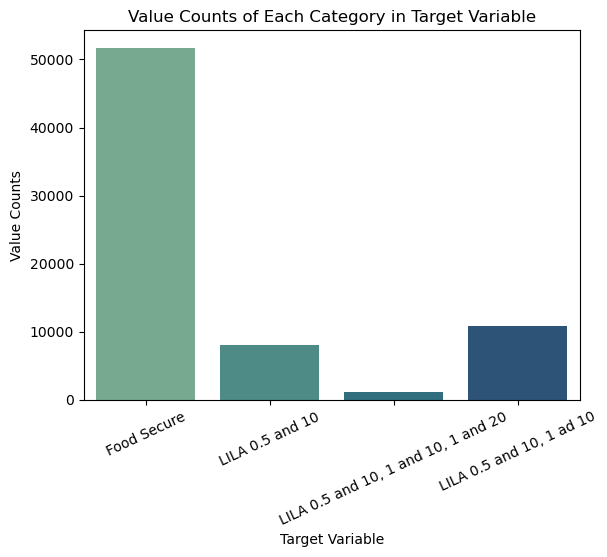

In [148]:
vals = sns.countplot(knnfara, x = "LILA_All", palette = 'crest')
vals.set_xticklabels(labels = ["Food Secure", "LILA 0.5 and 10", "LILA 0.5 and 10, 1 and 10, 1 and 20", "LILA 0.5 and 10, 1 ad 10"], 
                              rotation = 25)
plt.ylabel("Value Counts")
plt.xlabel("Target Variable")
plt.title("Value Counts of Each Category in Target Variable")

In [150]:
## train, test, split
knnfara.drop(columns = ['LILATracts_halfAnd10', 'LILATracts_1And10', 'LILATracts_1And20'])
X = knnfara.loc[ : , knnfara.columns != 'LILA_All']
y = knnfara['LILA_All']

X_retrain, X_retest, y_retrain, y_retest = train_test_split(X, y, test_size = 0.3, random_state = 48)

## sanity check train vals for proportions
y_train.value_counts(normalize = True)

LILATracts_halfAnd10  LILATracts_1And10  LILATracts_1And20
0                     0                  0                    0.720023
1                     0                  0                    0.150298
                      1                  1                    0.113360
                                         0                    0.016319
Name: proportion, dtype: float64

In [152]:
## sanity check test vals for proportions
y_test.value_counts(normalize = True)

LILATracts_halfAnd10  LILATracts_1And10  LILATracts_1And20
0                     0                  0                    0.722638
1                     0                  0                    0.152264
                      1                  1                    0.109821
                                         0                    0.015277
Name: proportion, dtype: float64

In [154]:
## resample to account for imbalanced data using ADASYN

adasyn = ADASYN(random_state = 12)
X_resampled, y_resampled = adasyn.fit_resample(X_retrain, y_retrain)

y_resampled.value_counts()

LILA_All
LILATracts_halfAnd10                                        37365
                                                            36216
LILATracts_halfAnd10,LILATracts_1And10                      36049
LILATracts_halfAnd10,LILATracts_1And10,LILATracts_1And20    34965
Name: count, dtype: int64

In [156]:
## rerun model with resampled ADASYN values
n = len(X_resampled)
k = math.sqrt(n) / 2

knn2 = KNeighborsClassifier(n_neighbors = int(k))
knn2.fit(X_resampled, y_resampled)

y_pred2 = knn2.predict(X_retest)

accuracy = accuracy_score(y_retest, y_pred2)
accuracy

0.6044114232644532

Text(0.5, 1.0, 'Confusion Matrix for kNN model (k = 5) ADASYN Resample')

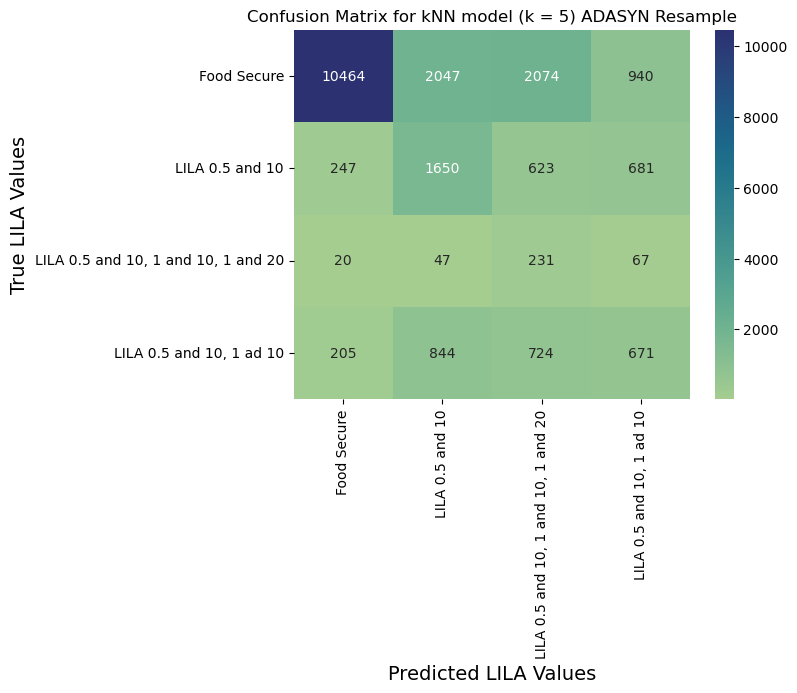

In [158]:
#confusion matrix ADASYN
conf = confusion_matrix(y_retest, y_pred2)
sns.heatmap(conf, annot = True, fmt = "d", cmap = "crest", 
            xticklabels = ["Food Secure", "LILA 0.5 and 10", "LILA 0.5 and 10, 1 and 10, 1 and 20", "LILA 0.5 and 10, 1 and 10"], 
           yticklabels = ["Food Secure", "LILA 0.5 and 10", "LILA 0.5 and 10, 1 and 10, 1 and 20", "LILA 0.5 and 10, 1 and 10"])
plt.xlabel("Predicted LILA Values", fontsize = 14)
plt.ylabel("True LILA Values", fontsize = 14)
plt.title("Confusion Matrix for kNN model (k = 5) ADASYN Resample")

In [175]:
## SMOTE resample
smote = SMOTE(random_state = 58)
X_sm_resampled, y_sm_resampled = smote.fit_resample(X_retrain, y_retrain)
y_sm_resampled.value_counts()

LILA_All
LILATracts_halfAnd10                                        36216
                                                            36216
LILATracts_halfAnd10,LILATracts_1And10,LILATracts_1And20    36216
LILATracts_halfAnd10,LILATracts_1And10                      36216
Name: count, dtype: int64

In [177]:
## rerun model with SMOTE values
knn1.fit(X_sm_resampled, y_sm_resampled)

y_pred3 = knn1.predict(X_retest)


0.6174135128859995

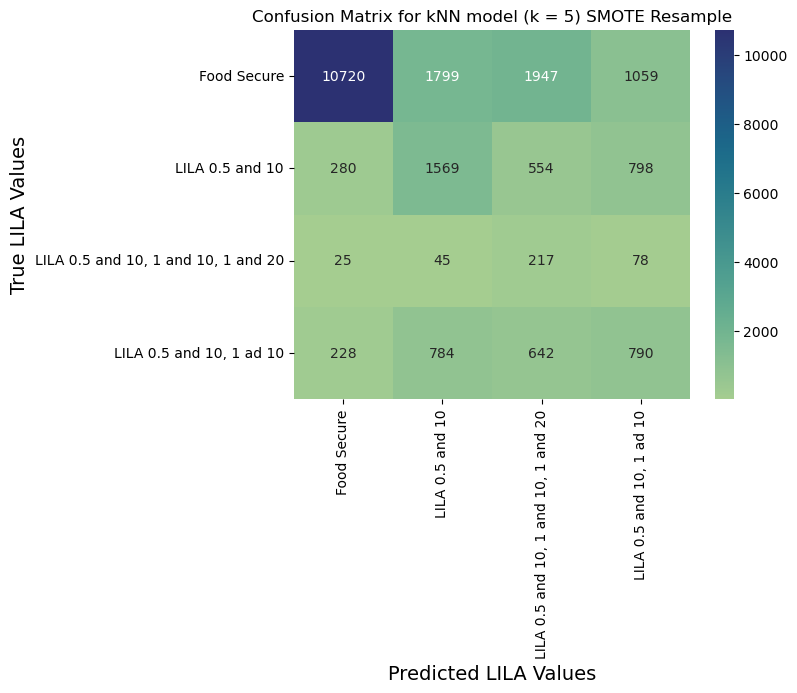

In [179]:
##confusion matrix SMOTE
conf = confusion_matrix(y_retest, y_pred3)
sns.heatmap(conf, annot = True, fmt = "d", cmap = "crest", 
            xticklabels = ["Food Secure", "LILA 0.5 and 10", "LILA 0.5 and 10, 1 and 10, 1 and 20", "LILA 0.5 and 10, 1 and 10"], 
           yticklabels = ["Food Secure", "LILA 0.5 and 10", "LILA 0.5 and 10, 1 and 10, 1 and 20", "LILA 0.5 and 10, 1 and 10"])
plt.xlabel("Predicted LILA Values", fontsize = 14)
plt.ylabel("True LILA Values", fontsize = 14)
plt.title("Confusion Matrix for kNN model (k = 5) SMOTE Resample")

##accuracy score
accuracy_score(y_retest, y_pred3)

## GridSearch kNN w/ SMOTE data

In [181]:
## set parameters and run gridsearch

params_kNN = {"n_neighbors": [300, 500], "weights": ['uniform', 'distance'], "algorithm": ['ball_tree', 'kd_tree', 'brute']}

grid_search = GridSearchCV(KNeighborsClassifier(), params_kNN, scoring='accuracy')

# Perform the grid search
grid_search.fit(X_sm_resampled, y_sm_resampled)

# Output the best parameters from the grid search
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 300, 'weights': 'distance'}


In [197]:
## run gridserach kNN with SMOTE applied
knngrid = KNeighborsClassifier(n_neighbors = 300, weights = 'distance', algorithm = 'ball_tree')

knngrid.fit(X_sm_resampled, y_sm_resampled)

y_predbest = knngrid.predict(X_retest)

In [199]:
accuracy_score(y_retest, y_predbest)

0.622892964940794

In [205]:
print(classification_report(y_retest, y_predbest, target_names=["Food Secure", "LILA 0.5 and 10", "LILA 0.5 and 10, 1 and 10, 1 and 20", "LILA 0.5 and 10, 1 and 10"]))

                                     precision    recall  f1-score   support

                        Food Secure       0.95      0.70      0.81     15525
                    LILA 0.5 and 10       0.39      0.50      0.44      3201
LILA 0.5 and 10, 1 and 10, 1 and 20       0.06      0.64      0.12       365
          LILA 0.5 and 10, 1 and 10       0.31      0.30      0.31      2444

                           accuracy                           0.62     21535
                          macro avg       0.43      0.54      0.42     21535
                       weighted avg       0.78      0.62      0.68     21535



In [207]:
## run gridserach kNN without SMOTE applied
knngrid = KNeighborsClassifier(n_neighbors = 300, weights = 'distance', algorithm = 'ball_tree')

knngrid.fit(X_train, y_train)

y_predbest = knngrid.predict(X_test)

In [221]:
accuracy_score(y_test, y_predbest)

0.7579753889017878

In [223]:
##classification report of model performance

print(classification_report(y_test, y_predbest, target_names=["LILATracts_halfand10", "LILATracts_1and10", "LILATracts_1and20"], 
                            zero_division = 0.0))

                      precision    recall  f1-score   support

LILATracts_halfand10       0.71      0.67      0.69      5973
   LILATracts_1and10       0.63      0.02      0.03      2694
   LILATracts_1and20       0.73      0.00      0.01      2365

           micro avg       0.71      0.37      0.49     11032
           macro avg       0.69      0.23      0.24     11032
        weighted avg       0.69      0.37      0.38     11032
         samples avg       0.19      0.14      0.15     11032

